# 計算をする量子回路の実装

量子計算をする回路の感覚がつかめてきたところで、量子計算をするとはどういうことかに話を移して行きましょう。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{|#1\rangle}$

## 量子計算の特徴

量子計算をするとはどういうことかを一概に決めることはできませんし、それ自体がまだ世界中で盛んに研究されているトピックです。ただ、現在知られている量子コンピュータの実用法に共通する大まかな特徴を挙げるならば、以下の2点になります。

- **並列性を利用する**：Equal superposition状態で見たように、$n$量子ビットがあるとき、比較的簡単な操作で$2^n$個の計算基底が顕に登場する状態が作れます。また、この状態には全ての量子ビットが関与するため、どのビットに対するゲート操作も全ての計算基底に影響を及ぼします。つまり、各ゲート操作が常に$2^n$重の並列演算となります。
- **干渉を利用する**：量子振幅は複素数なので、二つの振幅が足し合わされるとき、それぞれの位相によって和の振幅の値が変わります。特に絶対値が等しく位相が逆である（$\pi$だけ異なる）場合和が0となるので、そのことを利用して回路の量子状態の重ね合わせから特定の計算基底を除くといったことが可能です。

この2つの要素のうち、特に干渉を上手に使ったアルゴリズムを見出すのが難しいため、量子コンピュータの応用可能性にまだ未知数な部分が大きい、というのが現状です。

## 巨大SIMDマシンとしての量子コンピュータ

SIMD (single instruction multiple data)とは並列計算パラダイムの一つで、プロセッサの命令（instruction）が多数のデータに同時に適用されるケースを指します。私達の身の回りの（古典）コンピュータのプロセッサにもSIMD用のインストラクションセットが搭載されており、例えば（2021年11月現在）最先端の商用CPUでは、16個の単精度浮動小数点数に対し同時に四則演算や平方根の計算を行えます。

量子コンピュータでは、すべてのゲートがすべての計算基底に作用します。ゲート操作を命令、各計算基底の振幅をデータとして解釈すれば、これは常に$2^n$個のデータに命令を与えながら計算をしていることにあたります。量子コンピュータは巨大SIMDマシンとも考えられるのです。

ただし、すでに触れられたことですが、巨大並列計算ができたとしても、そのデータをすべて引き出すことはできません[^and_you_dont_want_to]ので、古典計算機のSIMDとはいろいろな意味で単純に比較できるものではありません。

とはいえ、並列計算を行っているんだということを実感できると、量子コンピュータの使い道のイメージも湧きやすくなると思われますので、今回の実習では量子計算の並列性が顕著に現れるような例を見ていきましょう。

[^and_you_dont_want_to]: そもそも、例えば65量子ビットの計算機からすべてのデータを保存しようと思うと、各振幅を128（古典）ビットの浮動小数点複素数で表現したとすれば512EiB (エクサバイト)のストレージが必要です。これはだいたい現在インターネットを行き来する情報二ヶ月分に相当するので、保存するファシリティを作るにはそれなりの投資が必要です。

(QFT)=
## 量子フーリエ変換

量子計算で並列性と振幅の干渉を巧みに利用した顕著な例として、量子フーリエ変換（Quantum Fourier transform, QFT）というサブルーチン（アルゴリズムの部品）があります。QFTは{doc}`Shorの素因数分解 <shor>`を含め多くのアルゴリズムに応用されています{cite}`nielsen_chuang_qft`。現在知られている中で最も重要な量子サブルーチンと言っても過言ではないでしょう。

QFTとは、$n$量子ビットレジスタの状態$\ket{j} \, (j \in \{0,1,\dots,2^n-1\})$を以下のように変換する操作です。

$$
U_{\mathrm{QFT}} \ket{j} = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i jk/2^n} \ket{k}
$$

QFTは量子回路で実装でき、線形なので、状態$\ket{\psi} = \sum_{j=0}^{2^n-1} c_j \ket{j}$に対しては

$$
\begin{split}
U_{\mathrm{QFT}} \ket{\psi} & = \frac{1}{\sqrt{2^n}} \sum_{j=0}^{2^n-1} c_j \sum_{k=0}^{2^n-1} e^{2\pi i jk/2^n} \ket{k} \\
& = \frac{1}{\sqrt{2^n}} \sum_{k=0}^{2^n-1} \tilde{c}_k \ket{k} \quad \left( \tilde{c}_k = \sum_{j=0}^{2^n-1} c_j e^{2\pi i jk/2^n} \right)
\end{split}
$$

となり、振幅$\{c_j\}_j$の離散フーリエ変換が引き起こされることがわかります。

古典計算機で$2^n$個のサンプルの離散フーリエ変換を計算するには$\mathcal{O}(n2^n)$回の演算が必要であることが知られています。一方、QFTは最も効率的な実装{cite}`qft_nlogn`で$\mathcal{O}(n \log n)$個のゲートしか利用しません（下の実装では$\mathcal{O}(n^2)$）。つまり、QCは古典計算機に比べて指数関数的に早くフーリエ変換を実行できます。

例として$n=6$の時のQFT回路を載せておきます。

In [1]:
# まずは全てインポート
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit.tools.monitor import job_monitor
from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit_ibm_provider.accounts import AccountNotFoundError
from qc_workbook.show_state import statevector_expr
from qc_workbook.optimized_additions import optimized_additions
from qc_workbook.utils import operational_backend, find_best_chain

print('notebook ready')

notebook ready


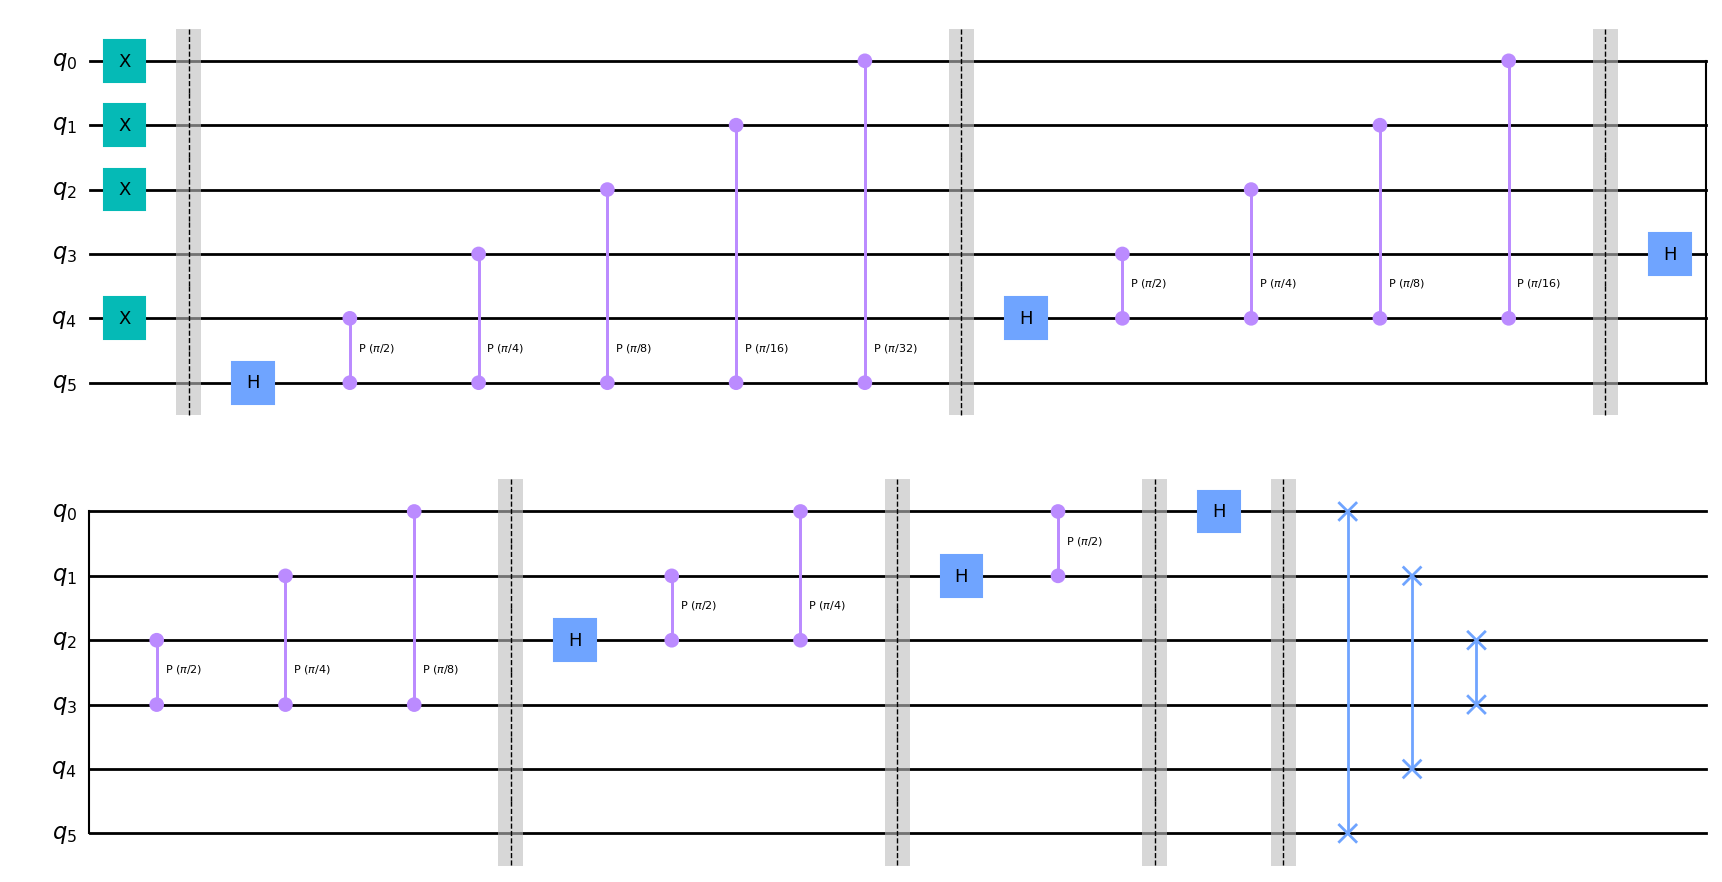

In [2]:
num_qubits = 6

circuit = QuantumCircuit(num_qubits)

# 具体的にするため、入力状態を|23>とする
j = 23

## jの２進数表現で値が1になっているビットに対してXを作用させる -> 状態|j>を作る

# まずjの２進数表現を得るために、unpackbitsを利用（他にもいろいろな方法がある）
# unpackbitsはuint8タイプのアレイを引数に取るので、jをその形に変換してから渡している
j_bits = np.unpackbits(np.asarray(j, dtype=np.uint8), bitorder='little')
# 次にj_bitsアレイのうち、ビットが立っているインデックスを得る
j_indices = np.nonzero(j_bits)[0]
# 最後にcircuit.x()
for idx in j_indices:
    circuit.x(idx)

## Alternative method
#for i in range(num_qubits):
#    if ((j >> i) & 1) == 1:
#        circuit.x(i)

circuit.barrier()

## ここからがQFT

# n-1から0まで標的ビットについてループ
for itarg in range(num_qubits - 1, -1, -1):
    # 標的ビットにアダマールゲートをかける
    circuit.h(itarg)
    # target - 1から0まで制御ビットについてループ
    for ictrl in range(itarg - 1, -1, -1):
        # 標的と制御ビットのインデックスに応じた角度で制御Pゲートをかける
        power = ictrl - itarg - 1 + num_qubits
        circuit.cp((2 ** power) * 2. * np.pi / (2 ** num_qubits), ictrl, itarg)

    # 回路図を見やすくするためにバリアを入れる
    circuit.barrier()

# 最後にビットの順番を反転させる
for i in range(num_qubits // 2):
    circuit.swap(i, num_qubits - 1 - i)

## ここまでがQFT

circuit.draw('mpl')

In [3]:
sqrt_2_to_n = 2 ** (num_qubits // 2)
amp_norm = (1. / sqrt_2_to_n, r'\frac{1}{%d}' % sqrt_2_to_n)
phase_norm = (2 * np.pi / (2 ** num_qubits), r'\frac{2 \pi i}{%d}' % (2 ** num_qubits))
expr = statevector_expr(circuit, amp_norm=amp_norm, phase_norm=phase_norm)
Math(expr)

<IPython.core.display.Math object>

上の回路でどうQFTが実現できるのか、初見で一目でわかる人は世界で数人しかいないでしょう。実際に状態を書き下しながら回路を追ってみましょう。

```{toggle}
まずビットn-1に着目します。前回の{ref}`equal_superposition_with_phase`の導出で行ったのと同様に、$j_m \, (m=0,\dots,n-1, \, j_m=0,1)$を使って$j$の二進数表現を$j=\sum_{m=0}^{n-1} 2^m j_m$としておきます。ビットn-1の初期状態は$\ket{j_{n-1}}_{n-1}$なので、アダマールゲートをかけると

$$
H\ket{j_{n-1}}_{n-1} = \frac{1}{\sqrt{2}} \left[\ket{0}_{n-1} + e^{2 \pi i \frac{j_{n-1}}{2}} \ket{1}_{n-1}\right]
$$

です。さらに、$j_{0}, \dots j_{n-2}$の情報をこのビットに盛り込むためにビット0からn-2まででそれぞれ制御した$C^m_{n-1}[P]$を使います。ただし、かける位相は制御ビットごとに異なります。

$$
\begin{align}
& C^{n-2}_{n-1}\left[P\left(\frac{2^{n-2} \cdot 2 \pi}{2^n}\right)\right] \cdots C^{0}_{n-1}\left[P\left(\frac{2 \pi}{2^n}\right)\right] (H\ket{j_{n-1}}_{n-1}) \ket{j_{n-2}}_{n-2} \cdots \ket{j_0}_0 \\
= & \frac{1}{\sqrt{2}} \left[\ket{0}_{n-1} + \exp \left(2 \pi i \frac{\sum_{m=0}^{n-1} 2^{m} j_m}{2^n}\right) \ket{1}_{n-1}\right] \ket{j_{n-2}}_{n-2} \cdots \ket{j_0}_0
\end{align}
$$

次に、ビットn-2にも同様の操作をします。ただし、制御はビットn-3以下からのみです。

$$
\begin{align}
& C^{n-3}_{n-2}\left[P\left(\frac{2^{n-2} \cdot 2 \pi}{2^n}\right)\right] \cdots C^{0}_{n-2}\left[P\left(\frac{2 \cdot 2 \pi}{2^n}\right)\right] (H\ket{j_{n-2}}_{n-2}) \cdots \ket{j_0}_0 \\
= & \frac{1}{\sqrt{2}} \left[\ket{0}_{n-2} + \exp \left(2 \pi i \frac{2 \sum_{m=0}^{n-2} 2^{m} j_m}{2^n}\right) \ket{1}_{n-2}\right] \ket{j_{n-3}}_{n-3} \cdots \ket{j_0}_0
\end{align}
$$

これをビット0まで繰り返します。制御は常に位数の小さいビットからです。

$$
\begin{align}
& C^{n-4}_{n-3}\left[P\left(\frac{2^{n-2} \cdot 2 \pi}{2^n}\right)\right] \cdots C^{0}_{n-3}\left[P\left(\frac{2^2 \cdot 2 \pi}{2^n}\right)\right] (H\ket{j_{n-3}}_{n-3}) \cdots \ket{j_0}_0 \\
= & \frac{1}{\sqrt{2}} \left[\ket{0}_{n-3} + \exp \left(2 \pi i \frac{2^2 \sum_{m=0}^{n-3} 2^{m} j_m}{2^n}\right) \ket{1}_{n-3}\right] \ket{j_{n-4}}_{n-4} \cdots \ket{j_0}_0
\end{align}
$$

$$
\dots
$$

$$
\begin{align}
& C^{0}_{1}\left[P\left(\frac{2^{n-2} \cdot 2 \pi}{2^n}\right)\right] (H\ket{j_{1}}_{1}) \ket{j_0}_0 \\
= & \frac{1}{\sqrt{2}} \left[\ket{0}_{1} + \exp \left(2 \pi i \frac{2^{n-2} \sum_{m=0}^{1} 2^{m} j_m}{2^n}\right) \ket{1}_{1}\right] \ket{j_0}_0
\end{align}
$$

$$
\begin{align}
& H\ket{j_0}_0 \\
= & \frac{1}{\sqrt{2}} \left[\ket{0}_0 + \exp \left(2 \pi i \frac{2^{n-1} \sum_{m=0}^{0} 2^{m} j_m}{2^n}\right) \ket{1}_{0}\right].
\end{align}
$$

ここまでの全ての操作を順に適用すると、

$$
(H_0) (C^{0}_{1}[P]H_1) \cdots (C^{n-2}_{n-1}[P] \cdots C^{0}_{n-1}[P]H_{n-1}) \, \ket{j_{n-1}}_{n-1} \ket{j_{n-2}}_{n-2} \cdots \ket{j_{0}}_0 \\
= \frac{1}{\sqrt{2^n}} \left[\ket{0}_{n-1} + \exp \left(2 \pi i \frac{\sum_{m=0}^{n-1} 2^{m} j_m}{2^n}\right) \ket{1}_{n-1}\right] \cdots \left[\ket{0}_0 + \exp \left(2 \pi i \frac{2^{n-1} \sum_{m=0}^{0} 2^{m} j_m}{2^n}\right) \ket{1}_0\right].
$$

$\newcommand{tk}{\bar{k}}$

全ての量子ビットに$\ket{0}$と$\ket{1}$が現れるので、右辺は振幅$\{c_k\}_k$を用いて$\sum_{k=0}^{2^n-1} c_k \ket{k}$の形で表せます。後の利便性のために計算基底のラベルを$k$ではなく$\tk$とし、$\tk$の二進数表現$\tk=\sum_{l=0}^{n-1} 2^l \tk_{l}$を使うと

$$
c_{\tk} = \exp \left(\frac{2 \pi i}{2^n} \sum_{l=0}^{n-1}\sum_{m=0}^{l} 2^{n-1-l+m} j_m \tk_l \right).
$$

二重和が厄介な形をしていますが、$j_m, \tk_l \in {0, 1}$なので、$n-1-l+m >= n$のとき和の中身が$2^n$の倍数となり、$\exp (2 \pi i / 2^n \cdot a 2^n) = 1 \, \forall a \in \mathbb{N}$であることを用いると、$m$についての和を$n-1$までに拡張できます。さらに$k_l = \tk_{n-1 - l}$と定義すると、

$$
c_{\tk} = \exp \left(\frac{2 \pi i}{2^n} \sum_{m=0}^{n-1} 2^m j_m \sum_{l=0}^{n-1} 2^l k_l \right).
$$

つまり、ここまでの操作で得られる状態は

$$
\frac{1}{\sqrt{2^n}} \sum_{k_l=0,1} \exp \left(\frac{2 \pi i}{2^n} j \sum_{l=0}^{n-1} 2^l k_l \right) \ket{k_0}_{n-1} \cdots \ket{k_{n-1}}_0
$$

です。

最後にSWAPを使ってビット順序を逆転させると、

$$
\begin{split}
& \frac{1}{\sqrt{2^n}} \sum_{k_l=0,1} \exp \left(\frac{2 \pi i}{2^n} j \sum_{l=0}^{n-1} 2^l k_l \right) \ket{k_{n-1}}_{n-1} \cdots \ket{k_{0}}_0 \\
= & \frac{1}{\sqrt{2^n}} \sum_{k} \exp \left(\frac{2 \pi i}{2^n} j k \right) \ket{k}
\end{split}
$$

が得られます。
```

(fourier_addition)=
## 量子フーリエ変換による足し算

これまで量子「計算機」の話をしていながら、単純であるはずの四則演算のやりかたについて触れていませんでした。理由は、実は量子コンピュータでは四則演算がそんなに単純でないから、です。

足し算を行う量子サブルーチンはいくつか知られていますが、その中で量子ビットの数や用いるゲートの種類の面で効率的なのが、フーリエ変換を用いたものです{cite}`quantum_addition`。ただの足し算にフーリエ変換を持ち出すのは奇妙に思えますが、実際に動かしてみるとなかなかスマートな手法であることがわかります。

このサブルーチンは自然数$a$と$b$が計算基底で表現されている二つの入力レジスタと一つの出力レジスタを使用し、以下のように状態を移します。

$$
\ket{0}_{\mathrm{out}}\ket{b}_{\mathrm{in2}}\ket{a}_{\mathrm{in1}} \rightarrow \ket{a+b}_{\mathrm{out}}\ket{b}_{\mathrm{in2}}\ket{a}_{\mathrm{in1}}
$$

計算の流れをかいつまんで言うと、まず出力レジスタがequal superposition状態に初期化され、そこに二つの入力レジスタを制御とした$C[P]$ゲートがかけられていきます。ポイントは$C[P]$を利用することで出力レジスタの計算基底の位相に$a + b$が現れることで、最後にそこに対して逆フーリエ変換（Inverse QFT）を行うと、今度は出力レジスタが$a + b$に対応した計算基底状態になるという仕組みです。

次のセルで定義された`setup_addition`関数がサブルーチンの実装です。コード中`circuit.h()`に量子ビット番号ではなくレジスタオブジェクトを渡しています。`setup_addition`のコード中にも説明がありますが、Qiskitでは便利のために、`QuantumObject`クラスの1量子ビットゲートのメソッドに量子ビット番号だけでなく、番号のリストやレジスタを渡して、含まれるすべての量子ビットに同じ操作をかけることができるようになっています。

In [4]:
def setup_addition(circuit, reg1, reg2, reg3):
    # reg3にequal superpositionを生成
    # QuantumCircuitの1量子ビットゲートに対応するメソッド（circuit.hなど）に単一の量子ビットの代わりに
    # レジスタや量子ビットのリストを渡すと、含まれる全ての量子ビットに同じゲートをかけてくれる
    circuit.h(reg3)

    # 位相の単位（dphiの整数倍の位相をCPゲートでかけていく）
    dphi = 2. * np.pi / (2 ** reg3.size)

    # reg1とreg2それぞれの量子ビットで制御する
    for reg_ctrl in [reg1, reg2]:
        # 制御ビットに関するループ
        for ictrl, qctrl in enumerate(reg_ctrl):
            # reg3の標的ビットに関するループ
            for itarg, qtarg in enumerate(reg3):
                # C[P(phi)], phi = 2pi * 2^{ictrl} * 2^{itarg} / 2^{n3}
                circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)

    # 回路図を見やすくするためのバリア
    circuit.barrier()

    # Inverse QFT
    for j in range(reg3.size // 2):
        circuit.swap(reg3[j], reg3[-1 - j])

    for itarg in range(reg3.size):
        for ictrl in range(itarg):
            power = ictrl - itarg - 1 + reg3.size
            circuit.cp(-dphi * (2 ** power), reg3[ictrl], reg3[itarg])

        circuit.h(reg3[itarg])

print('Defined function setup_addition')

Defined function setup_addition


サブルーチンを具体的に数式で追ってみましょう。

```{toggle}
まず、2つの入力レジスタをそれぞれ状態$\ket{a}$と$\ket{b}$に用意します。出力レジスタの初期状態は$\ket{0}$です。それぞれのレジスタは十分に大きい（レジスタ$i$のビット数を$n_i$として$2^{n_1} > a$, $2^{n_2} > b$, $2^{n_3} > a + b$）とします。

量子フーリエ変換は、ビット数$n$のレジスタの計算基底$\ket{j}$を

$$
U_{\mathrm{QFT}}\ket{j} = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i jk/2^n} \ket{k}
$$

という状態に変える操作でした。では、その逆を考えると、自然数$a+b < 2^n$について

$$
U_{\mathrm{QFT}}^{-1} \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} e^{2\pi i (a+b)k/2^n} \ket{k} = \ket{a+b}
$$

ができることがわかります。

左辺の状態を作るには、これも量子フーリエ変換のアルゴリズムを参考にします。自然数$a, b, k$の二進分解

$$
a = \sum_{m=0}^{n_1-1} 2^m a_m \\
b = \sum_{m=0}^{n_2-1} 2^m b_m \\
k = \sum_{m=0}^{n_3-1} 2^m k_m
$$

を用いて、

$$
\exp\left(2\pi i \frac{(a+b)k}{2^{n_3}}\right) = \left[\prod_{l=0}^{n_1-1}\prod_{m=0}^{n_3-1} \exp\left(2\pi i \frac{2^{l+m} a_l k_m}{2^{n_3}}\right)\right]\left[\prod_{l=0}^{n_2-1}\prod_{m=0}^{n_3-1} \exp\left(2\pi i \frac{2^{l+m} b_l k_m}{2^{n_3}}\right)\right]
$$

と書けることを利用します。つまり、レジスタ1または2の各ビットとレジスタ3の各ビットを一つずつ組み合わせて、両方のビットが1である（$a_l = k_m = 1$または$b_l = k_m = 1$の）ときに対応する分（$2\pi 2^{l + m} / 2^{n_3}$）位相を進めれば、左辺の状態ができあがります。

具体的には、まずレジスタ3をequal superpositionに用意し、レジスタ1の各ビットを制御、レジスタ3の各ビットを標的とした$C[P]$ゲートをかけていきます。

$$
\begin{align}
\ket{0}\ket{b}\ket{a} & \xrightarrow{H^{\otimes n_3}} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \ket{k} \ket{b}\ket{a} \\
& \xrightarrow{C^{1;0}_{3;0}[P(2\pi \cdot 2^0 \cdot 2^0/2^{n_3})]} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{a_0 k_0}{2^{n_3}} \right) \ket{k} \ket{b}\ket{a} \\
& \xrightarrow{C^{1;0}_{3;1}[P(2\pi \cdot 2^0 \cdot 2^1/2^{n_3})]} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{a_0 (k_0 + 2k_1)}{2^{n_3}} \right) \ket{k} \ket{b}\ket{a} \\
\cdots & \\
& \xrightarrow{C^{1;0}_{3;n_3 - 1}[P(2\pi \cdot 2^0 \cdot 2^{n_3 - 1}/2^{n_3})]} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{a_0 k}{2^{n_3}} \right) \ket{k} \ket{b}\ket{a} \\
& \xrightarrow{C^{1;1}_{3;0}[P(2\pi \cdot 2^1 \cdot 2^0/2^{n_3})]} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{a_0 k + 2a_1 k_0}{2^{n_3}} \right) \ket{k} \ket{b}\ket{a} \\
\cdots & \\
& \xrightarrow{C^{1;n_1 - 1}_{3;n_3 - 1}[P(2\pi \cdot 2^{n_1-1} \cdot 2^{n_3 - 1}/2^{n_3})]} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{a k}{2^{n_3}} \right) \ket{k} \ket{b}\ket{a}
\end{align}
$$

続いてレジスタ2のビットを制御として、同様の$C[P]$ゲートをかけていくと、

$$
\begin{align}
& \xrightarrow{C^{2;0}_{3;0}[P(2\pi \cdot 2^0 \cdot 2^0/2^{n_3})]} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{ak + b_0 k_0}{2^{n_3}} \right) \ket{k} \ket{b}\ket{a} \\
& \xrightarrow{C^{2;0}_{3;1}[P(2\pi \cdot 2^0 \cdot 2^1/2^{n_3})]} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{ak + b_0 (k_0 + 2k_1)}{2^{n_3}} \right) \ket{k} \ket{b}\ket{a} \\
\cdots & \\
& \xrightarrow{C^{2;0}_{3;n_3 - 1}[P(2\pi \cdot 2^0 \cdot 2^{n_3 - 1}/2^{n_3})]} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{(a + b_0) k}{2^{n_3}} \right) \ket{k} \ket{b}\ket{a} \\
& \xrightarrow{C^{2;1}_{3;0}[P(2\pi \cdot 2^1 \cdot 2^0/2^{n_3})]} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{(a + b_0) k + 2b_1 k_0}{2^{n_3}} \right) \ket{k} \ket{b}\ket{a} \\
\cdots & \\
& \xrightarrow{C^{2;n_2 - 1}_{3;n_3 - 1}[P(2\pi \cdot 2^{n_2 - 1} \cdot 2^{n_3 - 1}/2^{n_3})]} \frac{1}{\sqrt{2^{n_3}}} \sum_{k=0}^{2^{n_3}-1} \exp \left( 2\pi i \frac{(a + b) k}{2^{n_3}} \right) \ket{k} \ket{b}\ket{a}
\end{align}
$$

となり、めでたく$\ket{a+b}$のフーリエ変換状態が実現されました。
```

実際に`setup_addition`を使って足し算をしてみましょう。レジスタ1と2は4ビットとして、$a=9, b=13$を考えます。

n1=4, n2=4, n3=5


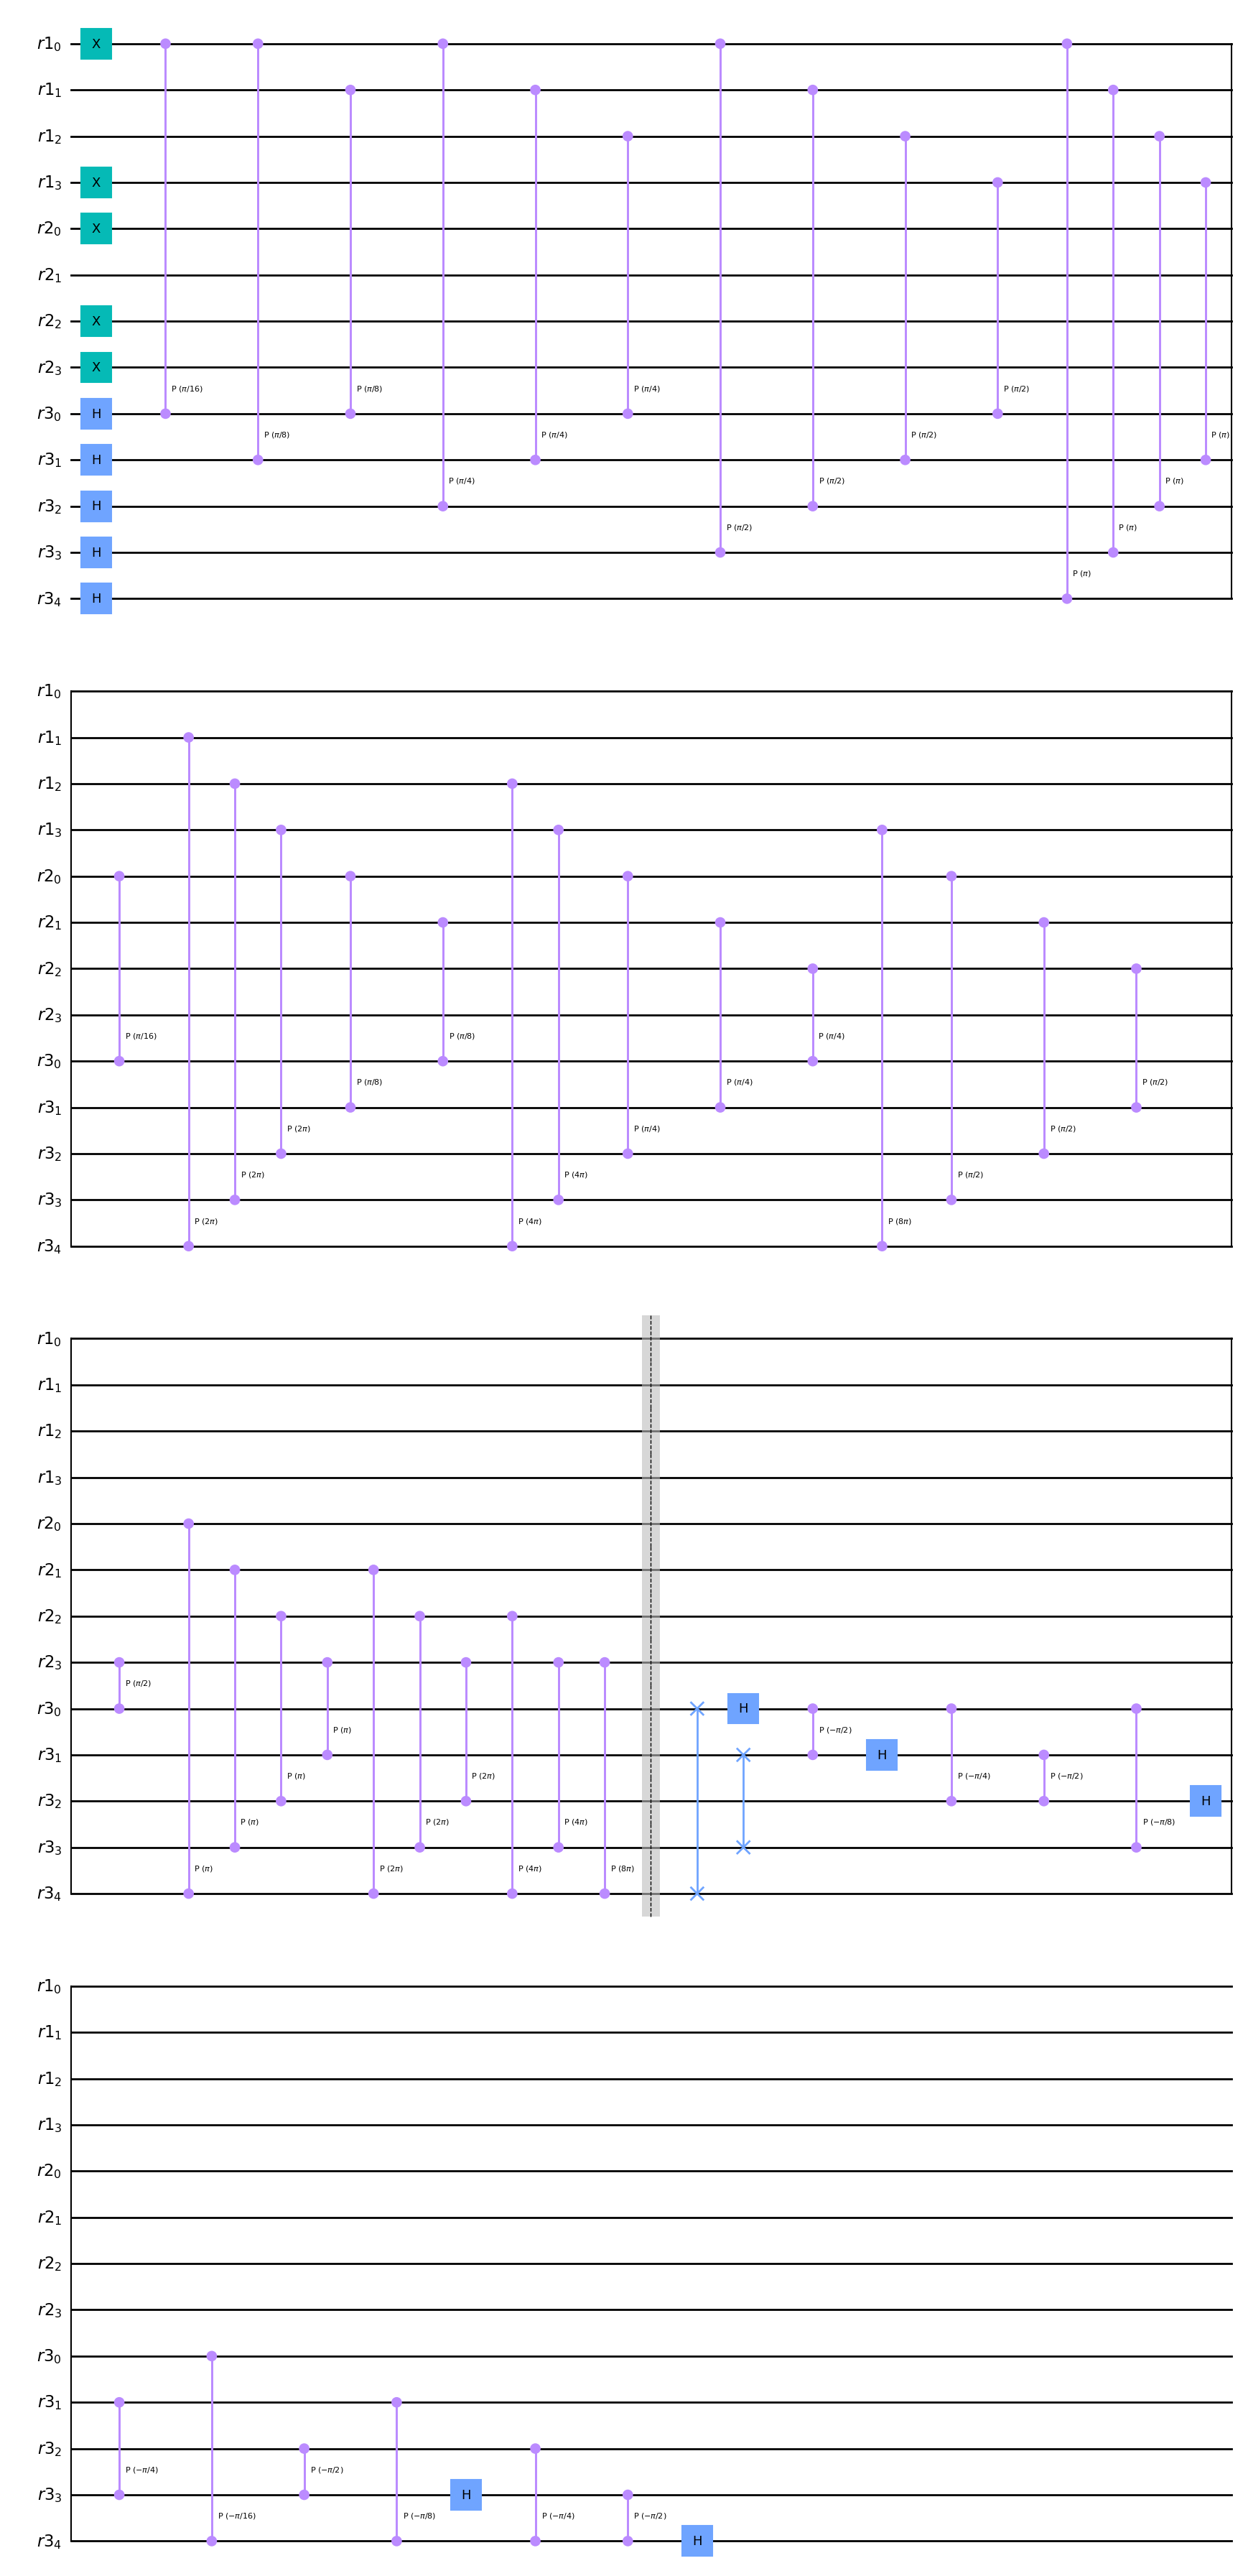

In [5]:
a = 9
b = 13

# 入力の値を二進数表現できる最小のビット数を計算
n1 = np.ceil(np.log2(a + 1)).astype(int)
n2 = np.ceil(np.log2(b + 1)).astype(int)
n3 = np.ceil(np.log2(a + b + 1)).astype(int)

print(f'n1={n1}, n2={n2}, n3={n3}')

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

# QuantumCircuitは量子ビット数の代わりにレジスタを渡しても作成できる
circuit = QuantumCircuit(reg1, reg2, reg3)

# reg1を|a>にする
a_bits = np.unpackbits(np.asarray(a, dtype=np.uint8), bitorder='little')
for idx in np.nonzero(a_bits)[0]:
    circuit.x(reg1[idx])

# reg2を|b>にする
b_bits = np.unpackbits(np.asarray(b, dtype=np.uint8), bitorder='little')
for idx in np.nonzero(b_bits)[0]:
    circuit.x(reg2[idx])

# 足し算ルーチンを呼ぶ
setup_addition(circuit, reg1, reg2, reg3)

# 回路図を確認
circuit.draw('mpl')

再び`statevector_expr`関数を使って終状態を確認してみましょう。

In [6]:
expr = statevector_expr(circuit, register_sizes=(n1, n2, n3))
Math(expr)

<IPython.core.display.Math object>

結果表示された状態は期待通り単一の計算基底$22:13:9$、つまりレジスタ1, 2, 3がそれぞれ$\ket{9}, \ket{13}, \ket{22}$となっている状態です（回路全体でビットを右から書いて状態を表示するため、レジスタも右から左に並びます）。つまり、めでたく状態の変遷

$$
\ket{0}\ket{13}\ket{9} \rightarrow \ket{22}\ket{13}\ket{9}
$$

が実現しました。

## 足し算の並列化

上では小学一年生ができる足し算を一回行うために13個の量子ビットと67個のゲートを利用しました。しかし、出来上がった回路は入力の値（9と13）によらず、4ビットで表現できる2つの整数すべてに対して成り立ちます（一般に2つの$n$ビット数の和は$n+1$ビットに収まるので、レジスタ3の大きさにも不足はありません）。さらに、量子演算は線形（つまり演算$U$について$U(\sum_{k} c_k \ket{k}) = \sum_{k} c_k U\ket{k}$）なので、初期状態としてレジスタ1と2がどんな計算基底の重ね合わせにあっても、それぞれの組み合わせに対してレジスタ3の状態が和を表してくれます。特に、初期状態がequal superpositionであれば、この回路は

$$
\frac{1}{\sqrt{2^{n_1 + n_2}}} \sum_{j=0}^{2^{n_1}-1} \sum_{k=0}^{2^{n_2}-1} \ket{0}\ket{k}\ket{j} \rightarrow \frac{1}{\sqrt{2^{n_1 + n_2}}} \sum_{j=0}^{2^{n_1}-1} \sum_{k=0}^{2^{n_2}-1} \ket{j+k}\ket{k}\ket{j}
$$

を行うので、$\mathcal{O}\left((n_1 + n_2 + n_3) n_3\right)$個のゲートで$2^{n_1+n_2}$通りの足し算を並列に行います。実際にこれを確認してみましょう。

In [7]:
n1 = 4
n2 = 4
n3 = np.ceil(np.log2((2 ** n1) + (2 ** n2) - 1)).astype(int)

reg1 = QuantumRegister(n1, 'r1')
reg2 = QuantumRegister(n2, 'r2')
reg3 = QuantumRegister(n3, 'r3')

circuit = QuantumCircuit(reg1, reg2, reg3)

# reg1とreg2をequal superpositionにする
circuit.h(reg1)
circuit.h(reg2)

setup_addition(circuit, reg1, reg2, reg3)

expr = statevector_expr(circuit, register_sizes=(n1, n2, n3), amp_norm=(1. / np.sqrt(2 ** (n1 + n2)), r'\frac{1}{\sqrt{2^{n_1 + n_2}}}'))
Math(expr)

<IPython.core.display.Math object>

2022年4月現在、IBMの持つ最大の量子コンピュータは127量子ビットです。このマシンを最大限利用するならば、$n_1 = n_2 = 42, n_3 = 43$で$2^{84}$通り、つまり約$2 \times 10^{25}$（20𥝱）通りの足し算を同時に行うことができます。

もちろん、上で書いたようにここには重要な但し書きがあって、実機でこの計算をして測定から答えを得ようとすると、毎回の測定でどの組み合わせが得られるかをコントロールできないので、これはあまり実用的とは言えない回路です。強いて言えば毎日ランダムに12桁＋12桁の正しい足し算を教えてくれる「日めくり足し算カレンダー」にくらいは使えます。$10^{23}$年程度使い続けられます。

## シミュレータでの実行

上の足し算回路の結果がランダムに出る様子をシミュレーションで確認しましょう。{doc}`addition_on_ibmq`では実機でも実行します。その際、上の回路実装では非効率的でエラーが出すぎるので、[専用に効率化した等価回路](https://github.com/UTokyo-ICEPP/qc-workbook/tree/master/source/qc_workbook/optimized_additions.py)を代わりに使用します。

In [8]:
# 元の回路に測定を加える
circuit.measure_all()
circuit_original = circuit

# 効率化した回路（測定付き）
circuit_optimized = optimized_additions(n1, n2)
print('Constructed an optimized addition circuit')

Constructed an optimized addition circuit


回路の効率化とは具体的にどういうことでしょうか。もともとの回路と効率化したものとを比べてみましょう。まずは、単純にオペレーションの数を比較します。ゲート一つ一つで一定の確率でエラーが起こるということは、同じことをする回路ならゲートの数が少ないほうがより正確な計算をしてくれます。

In [9]:
print('Number of operations in the original circuit:', circuit_original.size())
print('Number of operations in the optimized circuit:', circuit_optimized.size())

Number of operations in the original circuit: 83
Number of operations in the optimized circuit: 331


効率化したはずの回路のほうがはるかにゲート数が多いという結果になりました。なぜでしょうか。

(transpilation)=
### トランスパイルと物理的回路

これまで何度も登場しましたが、量子回路オブジェクトを実機やシミュレータの`run`メソッドに渡す前に、必ず`transpile`という関数を呼んでいました。この関数はトランスパイルという変換を回路に施します。実機においてトランスパイルとは、様々な複合ゲートからなる論理的な回路から、実機のハードウェアに実装されている「基本ゲート」のみで書かれる物理的な回路を作ることを言います[^physical]。

基本ゲートとは何でしょうか。実は、{ref}`第一回 <common_gates>`や{ref}`第二回の前半 <other_gates>`で様々なゲートを紹介しましたが、量子コンピュータの物理的実体（超伝導振動子など）で実際に行える量子操作にはごく少数の種類しかありません。例えば、IBMのマシンでは$X$, $\sqrt{X}$, $R_{z}$, CNOTの4通りです。しかし、この4つの組み合わせで全てのゲートを作ることができます。そのようなゲートの集合を基本ゲートと呼んでいます。

足し算回路の愚直な実装と効率化した実装の比較に話を戻すと、上で比べていたのはあくまで複合ゲートを使った論理的な回路でした。論理的な回路はどのようにでも書ける（極端に言えば回路全体を一つの「足し算ゲート」と呼んでしまうこともできる）ので、回路のゲート数の比較はトランスパイル後でなければ意味がありません。

いい機会なので、実機での量子計算について少し詳細に考えてみましょう。トランスパイルがまさに論理的なアルゴリズムの世界と物理的実装の世界のインターフェースとなるので、この過程に注目します。

トランスパイル時には、以下のような回路の変換が起こります。

- 冗長なゲートの削除
- 多重制御ゲートのCNOTと1量子ビットゲートへの分解
- 実機のトポロジーに即した量子ビットのマッピング（詳細は下）
- 物理的に隣接しない量子ビット間の制御ゲートを実行するためのSWAPの挿入
- 1量子ビットゲートの基本ゲートへの分解
- 物理的回路の最適化

実機のトポロジーとは、実際の量子プロセッサチップ上での量子ビット同士の繋がりかたのことを指します。2つの量子ビットが繋がっているとは、その間で基本制御ゲート（IBMQではCNOT）が実行できるということを意味します。これまで考慮してきませんでしたが、実はすべての量子ビットが繋がっているわけではないのです。例えば以前運用されていたibmq_16_melbourneというマシンは以下のようなトポロジーを持っていました。

```{image} figs/melbourne_topology.png
:height: 200px
```

図中、数字のついた丸が量子ビットを表し、線が量子ビット同士の繋がりを表します。

このように実機ごとにトポロジーが違うことなどが理由で、`transpile`関数には回路オブジェクトだけでなくバックエンドを引数として渡す必要があります。

直接接続のない量子ビット間で制御ゲートを実行する場合、SWAPを使って2つの量子ビットが隣り合うように状態を遷移させていく必要があります。例えば上のibmq_16_melbourneでビット2と6の間のCNOTが必要なら、（いくつか方法がありますが）2↔3, 3↔4, 4↔5とSWAPを繰り返して、5と6の間でCNOTを行い、ビットの並びを元に戻す必要があれば再度5↔4, 4↔3, 3↔2とSWAPをすることになります。

{ref}`ゲートの解説 <other_gates>`に出てきたように、SWAPは3つのCNOTに分解されます。つまり、直接接続のない量子ビット同士の制御ゲートが多出するような回路があると、莫大な数のCNOTが使われることになります。**CNOTのエラー率（ゲート操作一回あたりに操作の結果を間違える確率）は1量子ビットゲートのエラー率より一桁ほど高い**ので、これは大きな問題になります。そこで、論理的回路の量子ビットと実機の量子ビットとのマッピング（SWAPが発生すれば対応は変わっていくので、あくまで初期対応）と、回路中にどうSWAPを挿入していくかというルーティングの両方を上手に決めるということが、トランスパイルにおける中心的な課題です。

しかし、実は任意の回路に対して最適なマッピングとルーティングを探すという問題自体がいわゆるNP-hardな問題なので、qiskitのトランスパイル・ルーチンではこの問題の最適解を探してくれません。代わりにstochastic swapという、乱数を用いた手法が標準設定では利用されます。Stochastic swapは多くの回路で比較的効率のいいルーティングを作ることが知られていますが、乱数を利用するため実行のたびに異なるルーティングが出てくるなど、やや扱いにくい面もあります。また、単純な回路で事前に最適なルーティングがわかっている場合は、stochastic swapを使うべきではありません。

[^physical]: 「物理的」な回路もまだ実は論理的な存在であり、本当にハードウェアが理解するインストラクションに変換するには、さらに基本ゲートを特定のマイクロ波パルス列に直す必要があります。

### 回路の比較

上を踏まえて、改めて2つの足し算回路を比較してみましょう。

これまで`transpile`関数を回路とバックエンド以外の引数を渡さずに実行してきましたが、実はこの関数の実行時に様々なオプションを使ってトランスパイルの設定を細かくコントロールすることができます。今回の効率化した回路は一列に並んだ量子ビット列上でSWAPを一切使わずに実装できるようになっているので、stochastic swapを使用しないよう設定を変更してトランスパイルをします。バックエンド上のどの量子ビット列を使うかは、`find_best_chain`という関数で自動的に決めます。

本来は実機を使ってこの先の議論を進めたいところですが、2022年4月現在、`'ibm-q/open/main'`プロバイダを使っている場合、最大5量子ビットのマシンしか利用できないため、1ビット+1ビットの足し算回路しか作れず、意味のある比較になりません。そのため、openプロバイダを使っている場合は「フェイク」のバックエンド（実際のバックエンドに似せたシミュレータ）を使います。

In [10]:
# よりアクセス権の広いプロバイダを使える場合は、下を書き換える
instance = 'ibm-q/open/main'

if instance == 'ibm-q/open/main':
    from qiskit.test.mock import FakeGuadalupe

    backend = FakeGuadalupe()

else:
    try:
        provider = IBMProvider(instance=instance)
    except AccountNotFoundError:
        provider = IBMProvider(token='__paste_your_token_here__', instance=instance)

    backend_list = provider.backends(filters=operational_backend(min_qubits=13))
    backend = least_busy(backend_list)

print(f'Using backend {backend.name()}')

Using backend fake_guadalupe


/tmp/ipykernel_130/1998159444.py:5: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeGuadalupe


In [11]:
# オリジナルの回路をトランスパイルする。optimization_level=3は自動設定のうち、最も効率のいい回路を作る
# フェイクバックエンドの場合、少し時間がかかるので気長に待ってください
print('Transpiling the original circuit with standard settings')
circuit_original_tr = transpile(circuit_original, backend=backend, optimization_level=3)

# 効率化した回路をトランスパイルする。マシンのトポロジーに従い、最も合計エラー率の低い量子ビット列にマッピングする
print('Transpiling the optimized circuit with trivial mapping onto a chain of qubits')
initial_layout = find_best_chain(backend, n1 + n2 + n3)
circuit_optimized_tr = transpile(circuit_optimized, backend=backend,
                                 routing_method='basic', initial_layout=initial_layout,
                                 optimization_level=3)

# count_opsは回路に含まれる基本ゲートの数を辞書として返す
nops_orig = circuit_original_tr.count_ops()
nops_opt = circuit_optimized_tr.count_ops()

print(f'Number of operations in the original circuit: {circuit_original_tr.size()}')
print(f'  Breakdown: N(Rz)={nops_orig["rz"]}, N(X)={nops_orig["x"]}, N(SX)={nops_orig["sx"]}, N(CNOT)={nops_orig["cx"]}')
print(f'Number of operations in the optimized circuit: {circuit_optimized_tr.size()}')
print(f'  Breakdown: N(Rz)={nops_opt["rz"]}, N(X)={nops_opt["x"]}, N(SX)={nops_opt["sx"]}, N(CNOT)={nops_opt["cx"]}')

Transpiling the original circuit with standard settings


Transpiling the optimized circuit with trivial mapping onto a chain of qubits


Number of operations in the original circuit: 519
  Breakdown: N(Rz)=226, N(X)=13, N(SX)=104, N(CNOT)=163
Number of operations in the optimized circuit: 383


KeyError: 'x'

上のセルを実行すると、今度は効率化回路のオペレーションの全数が元の回路の8割、CNOTの数は6割という結果になることがわかります。

元の回路と効率化した回路の違いは、後者では「数珠つなぎ」になった量子ビット列というトポロジーを仮定して、制御ゲートの順番を工夫して直接明示的にSWAPを挿入していることです。さらに、可能なところでは$C[P]$ゲートの分解で生じるCNOTとSWAPのCNOTが打ち消し合うことも利用しています。最後の逆フーリエ変換でもゲートの順番が工夫してあります。

それでは、トランスパイルした回路を実行してみます。

In [ ]:
simulator = AerSimulator()

job_original = simulator.run(circuit_original_tr, shots=20)
counts_original = job_original.result().get_counts()

job_optimized = simulator.run(circuit_optimized_tr, shots=20)
counts_optimized = job_optimized.result().get_counts()

def plot_counts(counts, n1, n2, ax):
    heights = []
    labels = []

    for key, value in counts.items():
        heights.append(value)

        # countsのキーはひとつなぎの二進数なので、出力, 入力2, 入力1の値が読み取れるように切り分ける
        # 4 + 4 桁なら
        #  00110 0101 0001 -> 6 = 5 + 1
        #  n3    n2   n1
        x1 = int(key[-n1:], 2) # last n1 digits
        x2 = int(key[-n1 - n2:-n1], 2) # next-to-last n2 digits
        x3 = int(key[:-n1 - n2], 2) # first n3 digits
        labels.append('{} + {} = {}'.format(x1, x2, x3))

    x = np.linspace(0., len(labels), len(labels), endpoint=False)

    # 棒グラフをプロット
    ax.bar(x, heights, width=0.5)

    # ビジュアルを調整
    ax.set_xticks(x - 0.2)
    ax.set_xticklabels(labels, rotation=70)
    ax.tick_params('x', length=0.)

# サブプロットが縦に二つ並んだフィギュアを作成
fig, (ax_original, ax_optimized) = plt.subplots(2, figsize=[16, 10])

# サブプロット1: counts_original
plot_counts(counts_original, n1, n2, ax_original)

# サブプロット2: counts_optimized
plot_counts(counts_optimized, n1, n2, ax_optimized)

fig.subplots_adjust(bottom=-0.2)

両方の回路とも、正しい足し算の式がランダムに出現していることを確認してください。